In [85]:
from typing import List, Tuple, Union

import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras

import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

### Chargement des données.

In [4]:
# Scanners normaux.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), 'datasets', "CT-0.zip")
tf.keras.utils.get_file(filename, url)

# Scanners anormaux.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), 'datasets', "CT-23.zip")
tf.keras.utils.get_file(filename, url)

'/home/afiliot/Gitlab/TPDUIA/TPDUIA/datasets/CT-23.zip'

In [6]:
# On extrait les données dans le même dossier datasets/covid.
os.makedirs(os.path.join('datasets', 'covid'), exist_ok=True)
with zipfile.ZipFile(os.path.join("datasets", "CT-0.zip"), "r") as z_fp:
    z_fp.extractall("./datasets/covid/")

with zipfile.ZipFile(os.path.join("datasets", "CT-23.zip"), "r") as z_fp:
    z_fp.extractall("./datasets/covid/")

## Format DICOM

_Digital Imaging and COmmunications in Medicine_, couramment abrégée DICOM, est un standard pour la gestion informatique des données issues de l'imagerie médicale. Il a été créé en 1985 par l'_American College of Radiology_ et la _National Electric Manufacturers Association_ dans le but de standardiser les données transmises entre les différents appareils de radiologie. 

**L'objectif du standard DICOM est de faciliter les transferts d'images entre les machines de différents constructeurs. En effet, avant la généralisation de ce format, chaque constructeur de matériel d'imagerie utilisait un format de données propriétaire, entrainant d'importants problèmes de gestion et de maintenance (incompatibilités, coût, perte d'information) dans les établissements de santé.**

Une image au format DICOM est enregistrée sous forme de tableau de pixels avec les métadonnées associées. Les métadonnées comprennent des informations sur le patient, y compris le nom et la date de naissance. Les métadonnées comprennent également des informations sur l'image elle-même, telles que le nom de l'appareil utilisé pour acquérir l'image et certains paramètres d'imagerie.

Alors que plusieurs attributs DICOM dans les métadonnées doivent toujours être disponibles (par exemple le nom du patient), d'autres attributs DICOM sont uniques à un scanner ou à une machine particulière, ou propres à un type particulier d'imagerie, et peuvent donc ne pas être disponibles pour tous les fichiers DICOM. **Cela signifie que l'ensemble exact d'attributs disponibles dans un fichier DICOM particulier n'est pas garanti comme étant le même que les attributs d'un autre fichier DICOM.**

Ci-après sont exposés certains attributs standards particulièrement importants que l'on retrouve lors de la lecture d'image DICOM : le type d'image, l'orientation, la position, les paramètres servant à la conversion des intensités en HU (nous le verrons après), l'espace inter-pixels (distance physique en mm).

<img src="https://glassboxmedicine.files.wordpress.com/2021/02/dicomtable-1.png" width="600">



Malheureusement, les DICOM bruts ne peuvent pas être utilisés comme entrée directement pour les algorithmes d'apprentissage automatique. Les DICOM doivent d'abord être traités avant de pouvoir être analysés. Il existe différents _pipeline open-source_ de traitement qui permettent de passer des fichiers DICOM séparés (correspondant à différentes tranches d'un scanner) à un seul tableau numpy 3D compatible avec PyTorch, Tensorflow ou Keras. Voici l'une d'entre elles, particulièrement bien documentée : https://github.com/rachellea/ct-volume-preprocessing/blob/master/preprocess_volumes.py.

Dans les grandes lignes, voici les différentes étapes nécessaires au bon formattage des données DICOM :

- Empiler les tranches 2D du scanner dans le bon ordre;
- Vérifier à nouveau que le scanner est dans l'orientation souhaitée;
- Convertirles valeurs de pixel en unités Hounsfield (HU) en utilisant les attributs DICOM `RescaleSlope` et `RescaleIntercept`;
- Découper les valeurs de pixel à [-1000 HU, + 1000 HU], _i.e._ les limites inférieures et supérieures pratiques de l'échelle HU, correspondant respectivement aux radiodensités de l'air et de l'os;
- Utiliser `nibabel` ou `SimpleITK` pour rééchantillonner chaque volume à 0,8 x 0,8 x 0,8 mm pour permettre une signification de distance physique cohérente d'un pixel sur tous les patients;
- Convertir les valeurs de pixel en nombres entiers codés en 16 bits pour assurer la compression zip sans perte d'information tout en réduisant les besoins de stockage.

Nous n'aborderons pas la première étape puisque nos images sont par chance déjà bien alignées. Ceci étant, dans un fichier DICOM, l’attribut `ImageOrientationPatient` spécifie l’orientation du patient et est nécessaire pour déterminer quelle direction est la «direction z» (la direction de la tête aux pieds le long de laquelle les coupes axiales sont empilées). **En règle générale, les patients sont présentés dans l'orientation «1,0,0,0,1,0» pour un scanner thoracique, mais l'orientation est toujours importante à vérifier car elle peut parfois varier**.

Compte tenu de l'orientation du patient, il est possible de déterminer quelle valeur stockée dans l'attribut `ImagePositionPatient` est la position z. La position z reflète une mesure de distance physique de l'emplacement craniocaudal (de la tête aux pieds) de la tranche dans l'espace. En triant les tranches en fonction de leur position z, il est possible d'obtenir le bon ordre des tranches et de reconstruire le volume 3D complet.

Voir ce script python pour plus de détails : https://github.com/rachellea/ct-volume-preprocessing/blob/master/dicom_numpy/combine_slices.py.

### Conversion des intensités en HU

Les scanners sont des volumes (3D donc) dont les voxels ont une intensité s'exprimant dans une unité spécifique : les unités Hounsfield (ou _Hounsfield units_, HU). Les HU représentent la radiodensité d'un matériau (voir https://fr.wikipedia.org/wiki/%C3%89chelle_de_Hounsfield pour plus de détails avec quelques valeurs remarquables). 

**L'échelle des unités de Hounsfield (UH) est une transformation linéaire de la mesure du coefficient d'absorption original dans laquelle la densité de l'eau distillée, aux conditions normales de température et de pressionn est définie à zéro unité d'Hounsfield (UH), tandis que la densité de l'air est définie à −1 000 UH.** 

Dans un voxel avec un coefficient d'absorption moyen $\mu _{X}$, la valeur correspondante en UH est alors donnée par

$$ UH=1000\times \frac{\mu _{X}-\mu _{\text{eau}}}{\mu _{\text{eau}}} $$

où $\mu _{\text{eau}}$ est le coefficient d'absorption linéaire de l'eau.

Ainsi, une variation de une unité de Hounsfield (UH) représente une variation de 0,1 % du coefficient d'absorption de l'eau puisque le coefficient d'absorption de l'air est proche de zéro. 


<img src="https://glassboxmedicine.files.wordpress.com/2021/02/hounsfieldunits.png?w=1024" width="600">



Les valeurs de pixel brutes dans les DICOM ont subi une transformation linéaire des unités Hounsfield pour permettre un stockage sur disque efficace.

Cette transformation doit être inversée pour obtenir à nouveau des valeurs de pixels en unités Hounsfield (HU). La norme DICOM inclut les attributs `RescaleSlope` et `RescaleIntercept` qui sont le $m$ et le $b$ dans l'équation $y = mx + b$, nécessaires pour transformer linéairement les valeurs de pixels bruts $x$ stockées dans le tableau de pixels DICOM en unités Hounsfield $y$. Toutes les valeurs de pixel brutes du DICOM doivent être redimensionnées en HU à l'aide des attributs `RescaleSlope` et `RescaleIntercept`. Cela garantit qu'une valeur numérique particulière pour un pixel indique la même radiodensité sur tous les balayages. Généralement, `RescaleSlope` et `RescaleIntercept` sont généralement égaux à 1 et -1024, respectivement.

Après conversion en HU, les valeurs de pixel peuvent être mises dans l'intervalle [-1000 HU, + 1000 HU], qui représentent des limites inférieures et supérieures pratiques de l'échelle HU, correspondant respectivement aux radiodensités de l'air et de l'os.

Dans nos données, les intensités sont déjà en HU, et vont de -1024 à 2000. On les déplace alors dans l'intervalle -1000, 1000.

### Nos données

Les fichiers sont au format `nii.gz` et non DICOM, pour plus de simplicité. On parle le plus souvent de format `NIFTI` pour _Neuroimaging InFormatics Technology Initiative_ (2002).

Ce format est très usité dans le domaine de l'imagerie médicale (historiquement neuro-imagerie avec les IRM cérébrales) comme ici les scanners (ou _CT scans_), mais aussi les IRM, les radiographies ou les échographies.

Le package Python qui nous permettra de traiter ces images est le package `nibabel`, qui s'installe via la commande `!pip install nibabel`.

In [7]:
!pip install nibabel

     |████████████████████████████████| 3.3 MB 8.0 MB/s eta 0:00:01


In [8]:
import nibabel as nib

On créée une fonction pour lire et normaliser correctement les données.

In [14]:
def read_nifti_file(filepath: str):
    """Lecture du scanner."""
    # lecture.
    scan = nib.load(filepath)
    # récupération des données.
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalisation du volume entre -1000 et 1000, puis entre 0 et 1."""
    min = -1000
    max = 1000
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

### Resampling

En plus de garantir que les valeurs de pixel ont une radiodensité cohérente sur l'ensemble de nos données, il est également important de s'assurer que chaque pixel représente un volume cohérent au sein des volumes des patients. Un en-tête DICOM comprend l'attribut `PixelSpacing` qui comprend une mesure $x$ et une mesure $y$ en millimètres (espacement $x$ et espacement $y$). L'espacement $z$ (espacement craniocaudal) peut être déduit en soustrayant les valeurs de position $z$ des tranches adjacentes rapportées dans `ImagePositionPatient`. Pris ensemble, l'espacement (x, y, z) indique le volume physique en millimètres cubes qu'un seul voxel représente.

**Malheureusement, ces distances physiques varient en fonction des paramètres de numérisation, de sorte que la taille physique de chaque voxel est différente selon le patient. De plus, l'espacement (x, y) est souvent différent de l'espacement z pour un seul balayage !**

<img src="https://glassboxmedicine.files.wordpress.com/2021/02/pixelspacing.png" width="600">

Dans notre data set, les dimensions des voxels sont homogènes les uns avec les autres. On peut donc se passer de cette étape. Cependant, on peut utiliser la fonction `resize_volume` pour que chacun des volumes aient le même nombre de voxels selon les 3 dimensions.

In [13]:
from scipy import ndimage
import numpy as np

def resize_volume(volume: np.ndarray) -> np.ndarray:
    """Echantillonnage selon l'axe z."""
    # Paramètres z, x, y recherchés.
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Paramètres z, x, y observés sur l'image.
    # On suppose ici que ces paramètres sont identiques
    # quelque soit le voxel considéré sur le scanner
    # du patient.
    current_depth = volume.shape[2]
    current_width = volume.shape[0]
    current_height = volume.shape[1]
    # On calcule alors les ratios selon les 
    # 3 dimensions.
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    volume = ndimage.zoom(
        volume,
        (width_factor, height_factor, depth_factor),
        order=1
    )
    return volume

In [22]:
def process_scan(filepath: str) -> np.ndarray:
    """Read and resize volume"""
    # lecture.
    volume = read_nifti_file(filepath)
    # normalisation.
    volume = normalize(volume)
    # rotation.
    volume = ndimage.rotate(volume, 90, reshape=False)
    # échantillonage.
    volume = resize_volume(volume)
    return volume

### Lecture des scans

In [16]:
# "CT-0" : tissus pulmonaires normaux, pas de signes de pneumonie virale.
path_to_normal = os.path.join('datasets', 'covid', 'CT-0')
normal_scan_paths = [
    os.path.join(path_to_normal, x)
    for x in os.listdir(path_to_normal)
]
# "CT-23" : scan avec infiltrats en verre dépoli.
# C'est un aspect de halo aux limites floues, focalisé ou diffus, sans systématisation.
# L'arborescence vasculaire reste bien visible au sein de cet infiltrat.
# Le grossissement de l’image révèle un aspect réticulé parsemé de très fins micronodules,
# ou un seul de ces aspects. 
# Ces images correspondent à une hypertrophie inflammatoire du tissu interstitiel.
path_to_abnormal = os.path.join('datasets', 'covid', 'CT-23')
abnormal_scan_paths = [
    os.path.join(path_to_abnormal, x)
    for x in os.listdir(path_to_abnormal)
]
print(f"CT scans sain :{len(normal_scan_paths)}")
print(f"CT scans infectés :{len(abnormal_scan_paths)}")

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


### Construction des échantillons de train et validation.

Tout d'abord, on exécute les transformations précédentes _une seule fois_, on enregistre les données d'intérêt `x_train, y_train, x_val, y_val` dans `datasets/covid/`. 

In [79]:
pre_load = True
if not pre_load:
    abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
    normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
    # on définit les labels: 1 infecté, 0 sain.
    abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
    normal_labels = np.array([0 for _ in range(len(normal_scans))])
    # split 70/30 pour train / validation, soit 140/60 scans.
    x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
    y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
    x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
    y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
    # on enregistre les données.
    # pratique à améliorer : ne pas enregistrer au format pickle mais plutôt json !
    np.save(open('datasets/covid/x_train', 'wb'), x_train, allow_pickle=True)
    np.save(open('datasets/covid/x_val', 'wb'), x_val, allow_pickle=True)
    np.save(open('datasets/covid/y_train', 'wb'), y_train, allow_pickle=True)
    np.save(open('datasets/covid/y_val', 'wb'), y_val, allow_pickle=True)
else:
    x_train = np.load(open('datasets/covid/x_train', 'rb'))
    x_val = np.load(open('datasets/covid/x_val', 'rb'))
    y_train = np.load(open('datasets/covid/y_train', 'rb'))
    y_val = np.load(open('datasets/covid/y_val', 'rb'))

### Affichage des scans

In [56]:
import matplotlib.pyplot as plt

In [50]:
def plot_slices(
    image: np.ndarray,
    num_rows: int,
    num_columns: int,
    width: int = 128,
    height: int = 128
) -> None:
    """Affichage de 20 coupes 2D d'un volume donné par `data`."""
    assert num_rows * num_columns == image.shape[-1], "Le nombre de coupes doit correspondre aux nombres d'images souhaitées!"
    # rotation.
    data = np.rot90(np.array(image))
    # transposition.
    data = np.transpose(data)
    # on modifie la structure des coupes :
    # on passe de (128, 128, z) à (num_rows, num_columns, 128, 128)
    # attention, il faut que num_rows x num_columns = z !
    data = np.reshape(
        data, (num_rows, num_columns, width, height)
    )
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

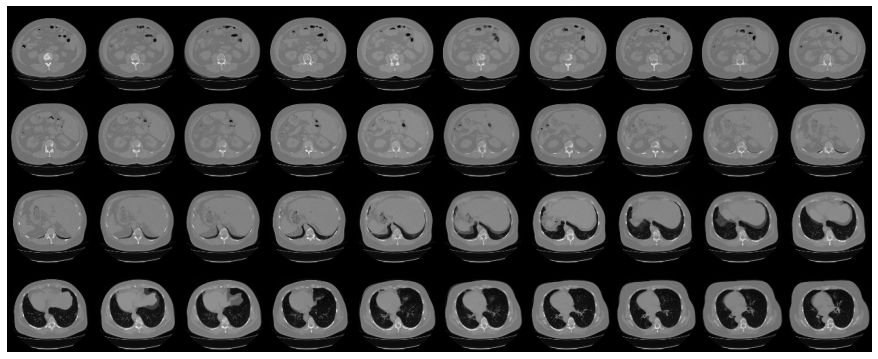

In [51]:
# premier exemple.
plot_slices(x_train[0][:, :, :40], 4, 10)

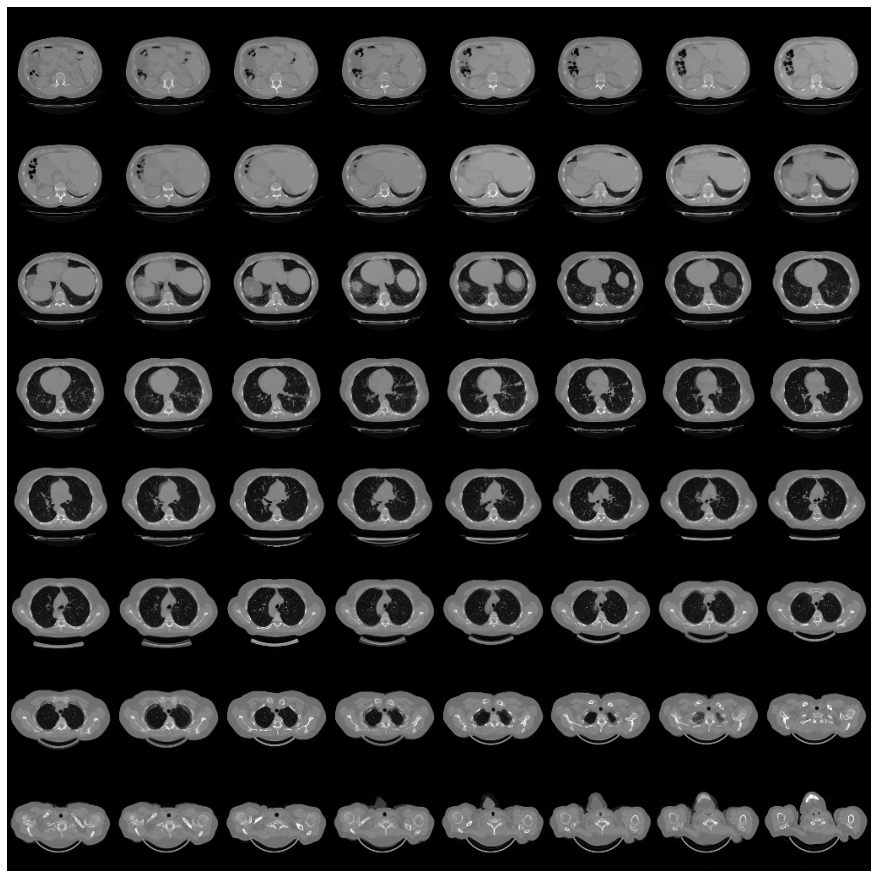

In [55]:
# deuxième exemple.
plot_slices(x_train[10], 8, 8)

## Pipelines d'entraînement et de validation

In [57]:
# On définit les générateurs (x, y) pour les deux échantillons
# avec la fonction `from_tensor_slices` de `tf.data.Dataset`.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

## Normalisation des volumes

In [110]:
def whitening(vol: np.ndarray) -> np.ndarray:
    """Moyenne 0, écart-type 1."""
    mean = np.mean(vol)
    std = np.std(vol)
    if std > 0:
        ret = (vol - mean) / std
    else:
        ret = vol * 0.
    return ret


def normalise_zero_one(vol: np.ndarray) -> np.ndarray:
    """Intensités normalisées entre 0 et 1."""
    minimum = np.min(vol)
    maximum = np.max(vol)
    if maximum > minimum:
        ret = (vol - minimum) / (maximum - minimum)
    else:
        ret = vol * 0.
    return ret


def normalise_one_one(vol: np.ndarray) -> np.ndarray:
    """Intensités normalisées entre -1 et 1."""
    ret = normalise_zero_one(vol)
    ret *= 2.
    ret -= 1.
    return ret

#### Visualisation

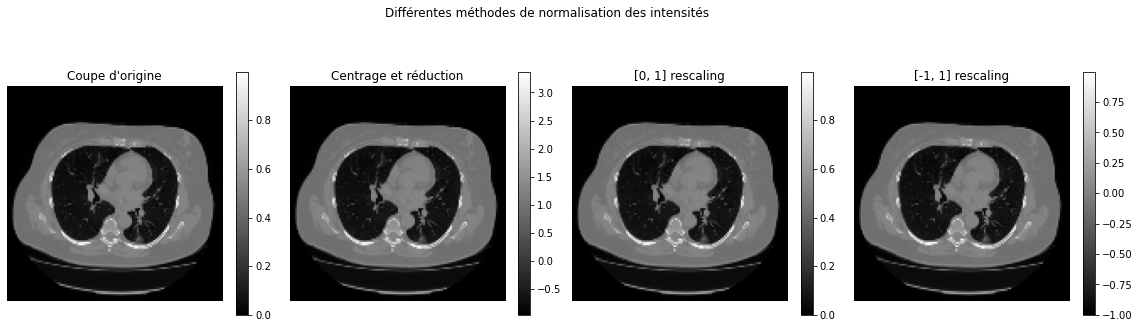

In [130]:
f, axarr = plt.subplots(1, 4, figsize=(20,5))
f.suptitle('Différentes méthodes de normalisation des intensités')

coupe = x_train[0][..., 40]

img = axarr[0].imshow(coupe, cmap='gray');
axarr[0].axis('off')
axarr[0].set_title("Coupe d'origine")
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(whitening(x_train[0])[..., 40]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Centrage et réduction')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(normalise_zero_one(x_train[0])[..., 40]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('[0, 1] rescaling')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(normalise_one_one(x_train[0])[..., 40]), cmap='gray');
axarr[3].axis('off')
axarr[3].set_title('[-1, 1] rescaling')
f.colorbar(img, ax=axarr[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

## Augmentation des volumes

In [260]:
def flip(vol: np.ndarray, axis : Union[int, List[int]] = 1) -> np.ndarray:
    """Flip selon les l'axe spécifié par `axis`."""
    # flip aléatoire avec probabilité 0.5.
    do_flip = np.random.random(1)
    volume = np.flip(vol, axis=axis) if do_flip > 0.5 else vol
    return volume


def add_gaussian_noise(vol: np.ndarray, sigma: float = 0.05) -> np.ndarray:
    """Ajout d'un bruit gaussien d'amplitude `sigma`."""
    do_noise = np.random.random(1)
    # bruitage avec probabilité 0.2.
    if do_noise:
        volume = vol + np.random.normal(0, sigma, vol.shape)
    else:
        volume = vol + 0.
    return volume.astype(np.float32)


def rotate(vol: np.ndarray, theta: float = 20) -> np.ndarray:
    """Rotation entre -theta° et theta°."""
    # on choisit alétaoirement un angle.
    angle = np.random.choice(np.linspace(-theta, theta, 100))
    # on procéde à une rotation.
    volume = ndimage.rotate(vol, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume


def elastic_transform(vol: np.ndarray, alpha: List[float], sigma: List[float]) -> np.ndarray:
    """Déformation élastique décrite par [1]
    [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
        Neural Networks applied to Visual Document Analysis", in Proc. of the
        International Conference on Document Analysis and Recognition, 2003.
    Basée sur la source suivante : https://gist.github.com/erniejunior/601cdf56d2b424757de5
    
    Args:
        alpha : échelle de déformation pour chaque dimension
                (l'intensité de la déformation augmente avec alpha).
        sigma : fenêtre de déformation pour chaque dimension
                (valeurs faibles associées à une déformation plus locale).
    """
    assert len(alpha) == len(sigma), \
        "Les tailles d'alpha et sigma doivent correspondre."
    channelbool = vol.ndim - len(alpha)
    out = np.zeros((len(alpha) + channelbool, ) + vol.shape)
    for jj in range(len(alpha)):
        array = (np.random.rand(*vol.shape) * 2 - 1)
        out[jj] = gaussian_filter(array, sigma[jj],
                                  mode="constant", cval=0) * alpha[jj]
    shapes = list(map(lambda x: slice(0, x, None), vol.shape))
    grid = np.broadcast_arrays(*np.ogrid[shapes])
    indices = list(map((lambda x: np.reshape(x, (-1, 1))), grid + np.array(out)))
    transformed_volume = map_coordinates(
        vol, indices, order=0,
        mode='reflect'
    ).reshape(vol.shape)
    return transformed_volume

#### Coupes d'origine

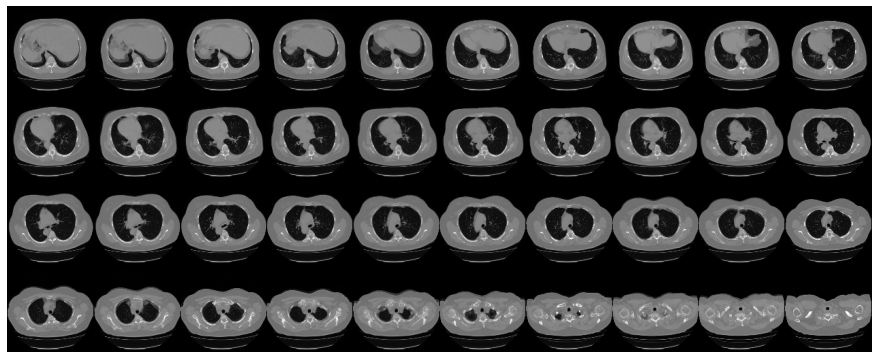

In [117]:
plot_slices(x_train[0][..., -40:], 4, 10)

#### Flip

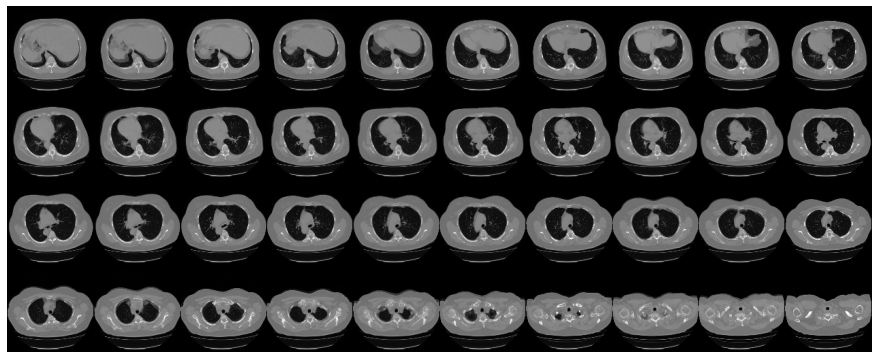

In [155]:
plot_slices(flip(x_train[0][..., -40:], axis=(0, 1)), 4, 10)

#### Rotation

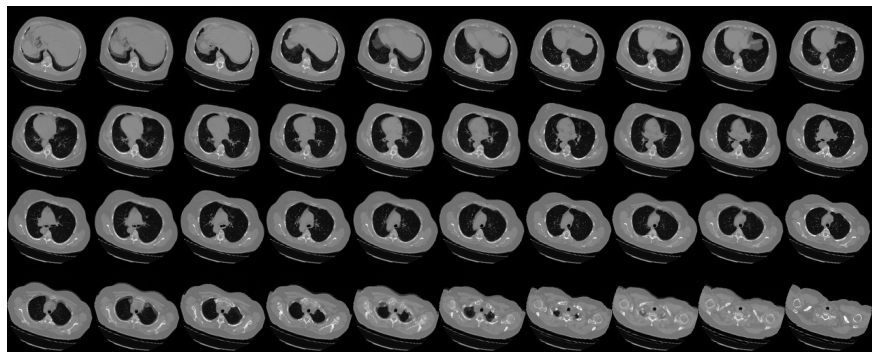

In [156]:
plot_slices(rotate(x_train[0][..., -40:], theta=30), 4, 10)

#### Bruit gaussien

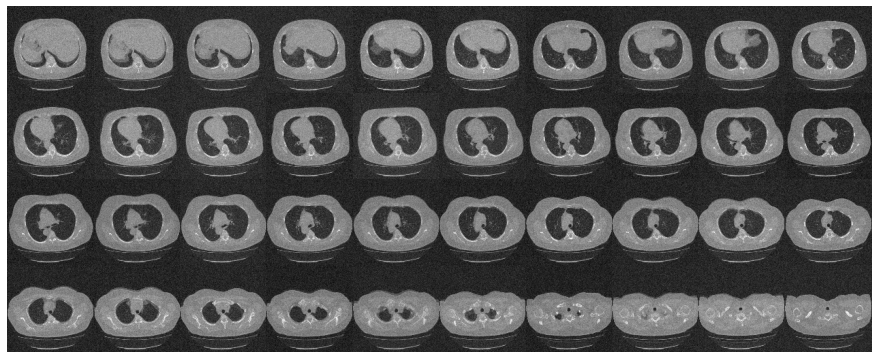

In [157]:
plot_slices(add_gaussian_noise(x_train[0][..., -40:], sigma=0.05), 4, 10)

#### Déformation élastique

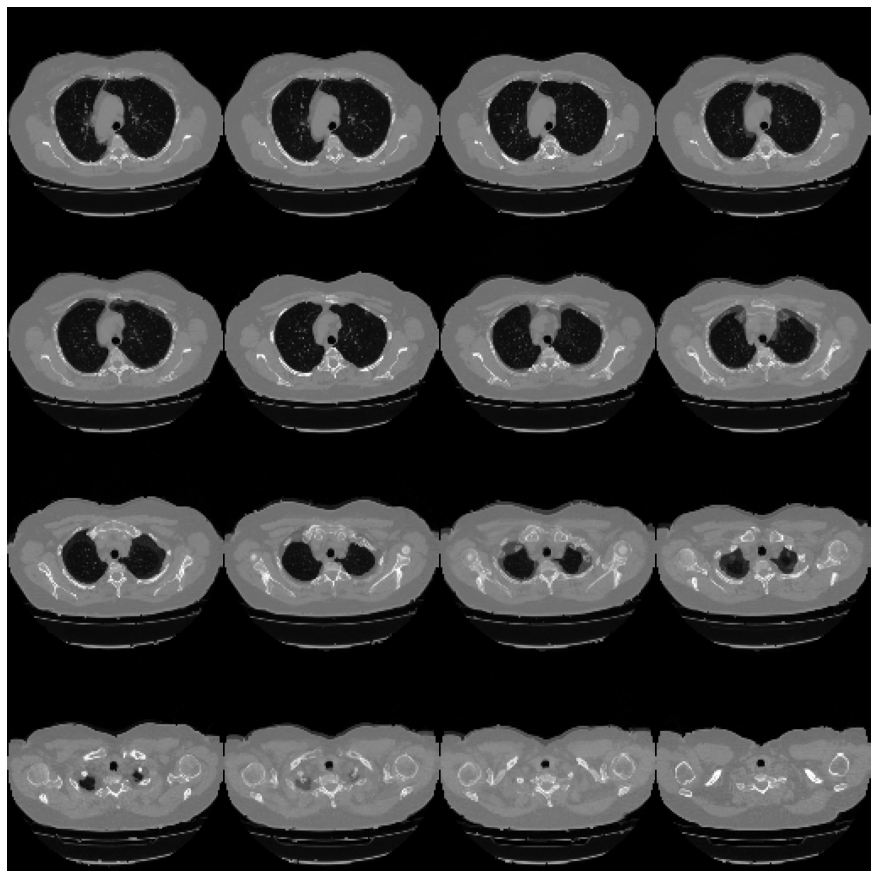

In [160]:
plot_slices(elastic_transform(x_train[0][..., -16:], alpha=[3, 3, 3], sigma=[1, 5, 5]), 4, 4)

### Exemple sur une coupe

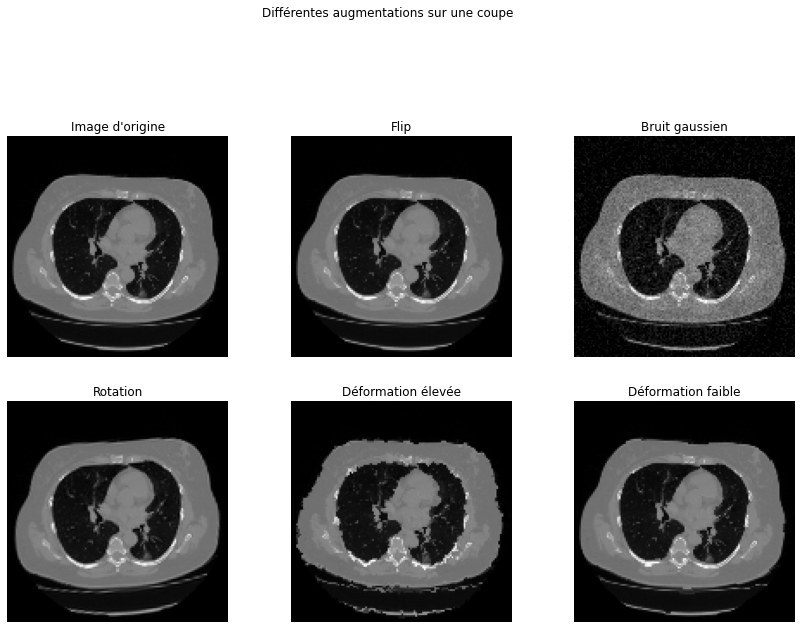

In [161]:
# Visualise using matplotlib
f, axarr = plt.subplots(2, 3, figsize=(15,10));
f.suptitle('Différentes augmentations sur une coupe')


axarr[0, 0].imshow(coupe, cmap='gray', vmin=0, vmax=1);
axarr[0, 0].axis('off')
axarr[0, 0].set_title("Image d'origine")

axarr[0, 1].imshow(flip(coupe, axis=(0, 1)), cmap='gray', vmin=0, vmax=1);
axarr[0, 1].axis('off')
axarr[0, 1].set_title('Flip')

axarr[0, 2].imshow(add_gaussian_noise(coupe), cmap='gray', vmin=0, vmax=1);
axarr[0, 2].axis('off')
axarr[0, 2].set_title('Bruit gaussien')

axarr[1, 0].imshow(rotate(coupe, theta=30), cmap='gray', vmin=0, vmax=1);
axarr[1, 0].axis('off')
axarr[1, 0].set_title('Rotation')

axarr[1, 1].imshow(elastic_transform(coupe, alpha=[3, 3], sigma=[1, 1]), cmap='gray', vmin=0, vmax=1);
axarr[1, 1].axis('off')
axarr[1, 1].set_title('Déformation élevée')

axarr[1, 2].imshow(elastic_transform(coupe, alpha=[10, 10], sigma=[5, 5]), cmap='gray', vmin=0, vmax=1);
axarr[1, 2].axis('off')
axarr[1, 2].set_title('Déformation faible')
    
f.subplots_adjust(wspace=0.05, top=0.8)
plt.show();

## Application des augmentations

In [264]:
@tf.function
def tf_whitening(x):
    return tf.numpy_function(whitening, [x], tf.float32)

@tf.function
def tf_flip(x):
    return tf.numpy_function(flip, [x], tf.float32)

@tf.function
def tf_rotate(x):
    return tf.numpy_function(rotate, [x], tf.float32)

@tf.function
def tf_add_gaussian_noise(x):
    return tf.numpy_function(add_gaussian_noise, [x], tf.float32)


augmentations = tf.keras.Sequential()
augmentations.add(tf.keras.layers.Lambda(tf_whitening)) # ceci n'est pas à proprement parler une augmentation.
augmentations.add(tf.keras.layers.Lambda(tf_flip))
augmentations.add(tf.keras.layers.Lambda(tf_rotate))
augmentations.add(tf.keras.layers.Lambda(tf_add_gaussian_noise))

In [265]:
def cast(volume: tf.Tensor):
    """Process training data by rotating and adding a channel."""
    return tf.expand_dims(volume, axis=3)

In [268]:
batch_size = 2
# Normalisation, augmentation et ajout d'une dimension. 
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(lambda x, y: (cast(augmentations(x)), y))
    .batch(batch_size)
    .prefetch(2)
)
# Normalisation et ajout d'une dimension.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(lambda x, y: (cast(tf_whitening(x)), y))
    .batch(batch_size)
    .prefetch(2)
)

## Définition du modèle

In [270]:
def get_model(width: int = 128, height: int = 128, depth: int = 64):
    """CNN 3D."""

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model

model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 14, 64)    256   

## Entraînement

In [ ]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=10, verbose=1,
    mode='auto', min_delta=0.0001
)

logger = tf.keras.callbacks.CSVLogger('models/covid/history.csv', separator=',')

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    metrics=["acc"],
)
os.makedirs('models/covid/', exist_ok=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "models/covid/3dcnn.h5", save_best_only=True
)

epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[lr_schedule, logger],
)

Epoch 1/100
70/70 [==============================] - 33s 444ms/step - loss: 0.5649 - acc: 0.7174 - val_loss: 0.6899 - val_acc: 0.6000
Epoch 2/100
70/70 [==============================] - 30s 426ms/step - loss: 0.4603 - acc: 0.7957 - val_loss: 1.5321 - val_acc: 0.5000
Epoch 3/100
70/70 [==============================] - 30s 427ms/step - loss: 0.4233 - acc: 0.8507 - val_loss: 1.9755 - val_acc: 0.5000
Epoch 4/100
55/70 [======================>.......] - ETA: 6s - loss: 0.4184 - acc: 0.8018

## Digression avec l'IRM

In [ ]:
plot_slices(x_train[0][..., -40:], 4, 10)

### Ressources supplémentaires

- DLTK : https://github.com/DLTK/DLTK